# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация. 

### Общая информация
Дата выдачи: 29.10.2021

Мягкий дедлайн: 23:59MSK 10.11.2021 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 13.11.2021

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-classification-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-classification-IvanovIvan.ipynb).

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter('ignore')
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Часть 0. SVM, LR и калибровка вероятностей. 

Сгенерируем синтетические данные.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=10000,
                           n_features=10,
                           n_informative=5,
                           n_redundant=5,
                           random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)

__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). __Здесь и далее, если не сказано иначе, подбирайте оптимальные гиперпараметры с точки зрения AUC-PR.__

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import auc, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import time

scaler = StandardScaler()

In [ ]:
def auc_pr_score(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    auc_score = auc(recall, precision)
    return np.round(auc_score, 5)

In [ ]:
def get_svc_score(C):
    skf = StratifiedKFold(5, shuffle=True, random_state=42)
    score_list = []
    for trn_index, val_index in skf.split(X_train, y_train):
        X_tr = X_train[trn_index]
        y_tr = y_train[trn_index]
        X_va = X_train[val_index]
        y_va = y_train[val_index]
        model = LinearSVC(C=C, max_iter=50000)
        model.fit(X_tr, y_tr)
        preds = model.decision_function(X_va)
        score_list.append(auc_pr_score(y_va, preds))
    return np.round(np.mean(score_list), 5)

In [ ]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
c_values = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
search_c = pd.Series(index=c_values, dtype=float)
for c in c_values:
    search_c[c] = get_svc_score(C=c)

In [ ]:
display(search_c)
print(f"Best AUC_PR score {search_c.idxmax()}, best C = {search_c.max()}")

0.000001    0.79205
0.000010    0.80289
0.000100    0.82322
0.001000    0.82394
0.010000    0.82327
0.100000    0.82314
1.000000    0.82310
dtype: float64

Best AUC_PR score 0.001, best C = 0.82394


На тестовой части постройте ROC и PR кривые, а также посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора (который на каждом объекте выдаёт один из двух классов с равными вероятностями).

In [ ]:
%time
model = model = LinearSVC(C=0.001, max_iter=50000)
model.fit(X_train, y_train)
test_preds = model.decision_function(X_test)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.11 µs


In [ ]:
random_preds = np.random.choice([0, 1], size=len(y_test))

In [ ]:
print(f"AUC-ROC for SVC predictions: {roc_auc_score(y_test,test_preds):.5f}",
      end=' ')
print(f"and for random predictions: {roc_auc_score(y_test,random_preds):.5f}")
print(f"AUC-PR for SVC predictions: {auc_pr_score(y_test,test_preds):.5f}",
      end=' ')
print(f"and for random predictions: {auc_pr_score(y_test,random_preds):.5f}")

AUC-ROC for SVC predictions: 0.84718 and for random predictions: 0.48665
AUC-PR for SVC predictions: 0.83058 and for random predictions: 0.61974


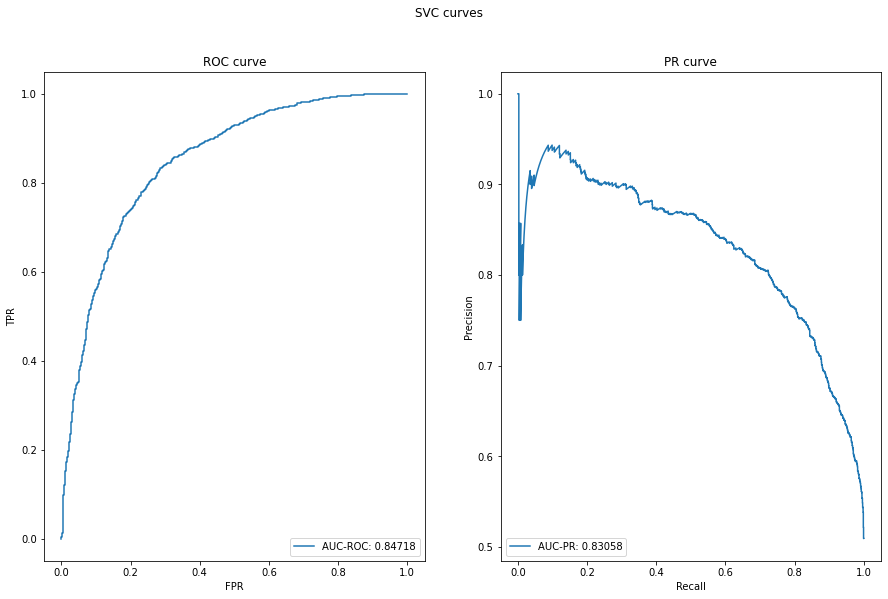

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 9))
fpr, tpr, _ = roc_curve(y_test, test_preds)
ax[0].plot(fpr, tpr, label=f"AUC-ROC: {roc_auc_score(y_test,test_preds):.5f}")
ax[0].set_xlabel('FPR')
ax[0].set_ylabel('TPR')
ax[0].set_title('ROC curve')
ax[0].legend(loc='lower right')

precision, recall, _ = precision_recall_curve(y_test, test_preds)
ax[1].plot(recall,
           precision,
           label=f"AUC-PR: {auc_pr_score(y_test,test_preds):.5f}")
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('PR curve')
ax[1].legend(loc='lower left')

fig.suptitle("SVC curves")
plt.show()

А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

In [ ]:
def get_logreg_score(C):
    skf = StratifiedKFold(5, shuffle=True, random_state=42)
    score_list = []
    for trn_index, val_index in skf.split(X_train, y_train):
        X_tr = X_train[trn_index]
        y_tr = y_train[trn_index]
        X_va = X_train[val_index]
        y_va = y_train[val_index]
        model = LogisticRegression(C=C)
        model.fit(X_tr, y_tr)
        preds = model.predict_proba(X_va)[:, 1]
        score_list.append(auc_pr_score(y_va, preds))
    return np.round(np.mean(score_list), 5)

In [ ]:
c_values = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
logreg_search_c = pd.Series(index=c_values, dtype=float)
for c in c_values:
    logreg_search_c[c] = get_logreg_score(C=c)

In [ ]:
display(logreg_search_c)
print(
    f"Best AUC_PR score {logreg_search_c.idxmax()}, best C = {logreg_search_c.max()}"
)

0.000001    0.79060
0.000010    0.79244
0.000100    0.80467
0.001000    0.82263
0.010000    0.82305
0.100000    0.82228
1.000000    0.82214
dtype: float64

Best AUC_PR score 0.01, best C = 0.82305


In [ ]:
%time
model = LogisticRegression(C=0.01)
model.fit(X_train, y_train)
logreg_preds = model.predict_proba(X_test)[:, 1]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


In [ ]:
print(
    f"AUC-ROC for Logistic Regression predictions: {roc_auc_score(y_test,logreg_preds):.5f}",
    end=' ')
print(f"and for random predictions: {roc_auc_score(y_test,random_preds):.5f}")
print(
    f"AUC-PR for Logistic Regression predictions: {auc_pr_score(y_test,logreg_preds):.5f}",
    end=' ')
print(f"and for random predictions: {auc_pr_score(y_test,random_preds):.5f}")

AUC-ROC for Logistic Regression predictions: 0.84734 and for random predictions: 0.48665
AUC-PR for Logistic Regression predictions: 0.83028 and for random predictions: 0.61974


 Время обучения и прогноза, а также качество у моделей практически одинаковое

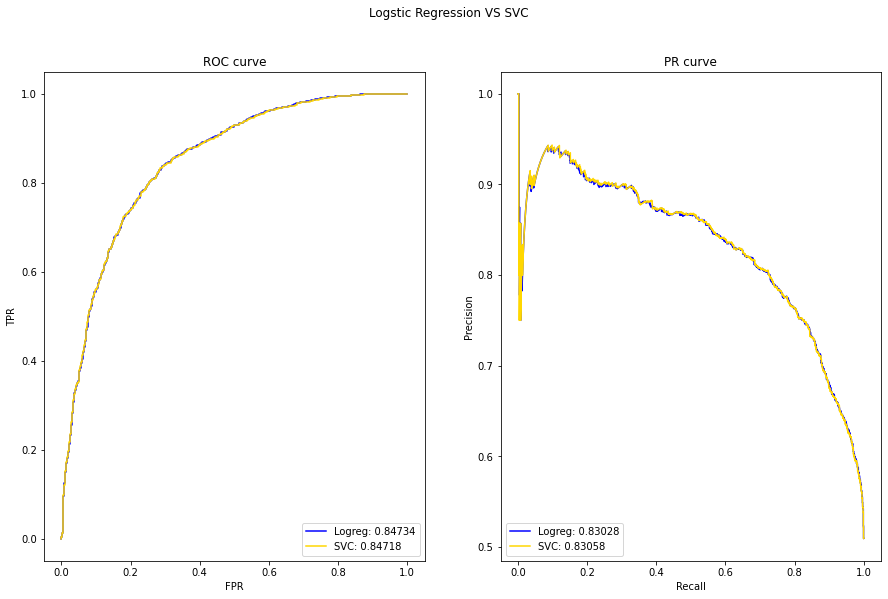

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 9))
fpr1, tpr1, _ = roc_curve(y_test, logreg_preds)
ax[0].plot(fpr1,
           tpr1,
           label=f'Logreg: {roc_auc_score(y_test,logreg_preds):.5f}',
           color='blue')
ax[0].plot(fpr,
           tpr,
           label=f'SVC: {roc_auc_score(y_test,test_preds):.5f}',
           color='gold')
ax[0].set_xlabel('FPR')
ax[0].set_ylabel('TPR')
ax[0].set_title('ROC curve')
ax[0].legend(loc='lower right')

precision1, recall1, _ = precision_recall_curve(y_test, logreg_preds)
ax[1].plot(recall1,
           precision1,
           label=f"Logreg: {auc_pr_score(y_test,logreg_preds):.5f}",
           color='blue')
ax[1].plot(recall,
           precision,
           label=f"SVC: {auc_pr_score(y_test,test_preds):.5f}",
           color='gold')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('PR curve')
ax[1].legend(loc='lower left')

fig.suptitle("Logstic Regression VS SVC")
plt.show()

В названии метода опорных векторов присутствуют некоторые "опорные векторы". Сгенерируйте синтетические данные с помощью `make_classification` с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). В этот раз, если необходимо, вместо `LinearSVC` воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах.

In [ ]:
X, y = make_classification(n_samples=200,
                           n_features=2,
                           n_informative=2,
                           n_redundant=0,
                           random_state=42)
X = scaler.fit_transform(X)
model = SVC(kernel='linear')
model.fit(X, y)

SVC(kernel='linear')

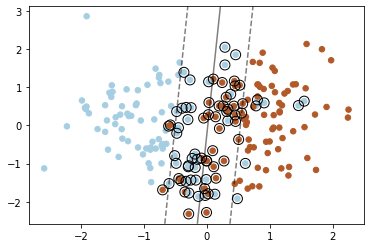

In [ ]:
# from https://medium.com/swlh/visualizing-svm-with-python-4b4b238a7a92
ax = plt.gca()
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 100)
yy = np.linspace(ylim[0], ylim[1], 100)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model.decision_function(xy).reshape(XX.shape)

ax.contour(XX,
           YY,
           Z,
           colors='k',
           levels=[-1, 0, 1],
           alpha=0.5,
           linestyles=['--', '-', '--'])

ax.scatter(model.support_vectors_[:, 0],
           model.support_vectors_[:, 1],
           s=100,
           linewidth=1,
           facecolors='none',
           edgecolors='k')
plt.show()

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor`.

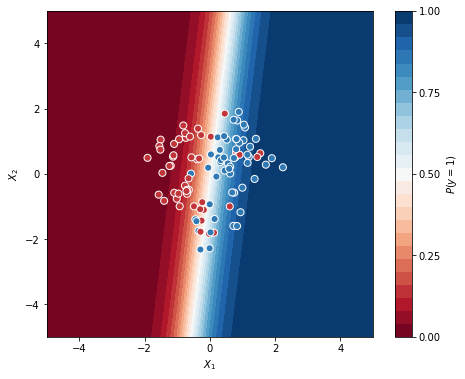

In [ ]:
# from https://stackoverflow.com/questions/28256058/plotting-decision-boundary-of-logistic-regression
model = LogisticRegression()
model.fit(X, y)

xx, yy = np.mgrid[-5:5:.01, -5:5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:, 0],
           X[100:, 1],
           c=y[100:],
           s=50,
           cmap="RdBu",
           vmin=-.2,
           vmax=1.2,
           edgecolor="white",
           linewidth=1)

ax.set(aspect="equal",
       xlim=(-5, 5),
       ylim=(-5, 5),
       xlabel="$X_1$",
       ylabel="$X_2$")
plt.show()

__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [ ]:
"""
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l - r) / 2) 
        bin_real_ratios.append(np.min(y_test[(preds >= l) & (preds < r)] == 1)) 
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()
"""

In [ ]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l)
                                              & (preds < r)] == 1))
    plt.figure(figsize=(6, 6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`). Чем они различаются? Чем вы можете объяснить это?

In [ ]:
def sigmoid(x):
    return (1 / (1 + np.exp(-x)))

In [ ]:
X, y = make_classification(n_samples=10000,
                           n_features=10,
                           n_informative=5,
                           n_redundant=5,
                           random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg_preds = logreg.predict_proba(X_test)[:, 1]
svc = LinearSVC(max_iter=10000)
svc.fit(X_train, y_train)
svc_preds = sigmoid(svc.decision_function(X_test))

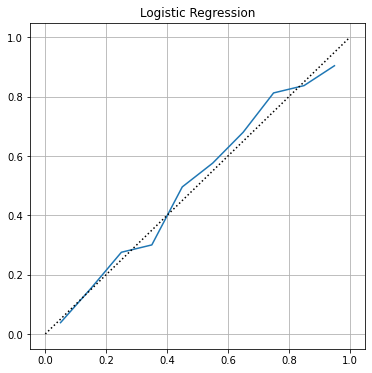

In [ ]:
plot_calibration_curve(y_test, logreg_preds)
plt.plot([0, 1], [0, 1], linestyle='dotted', color='black')
plt.title('Logistic Regression')
plt.show()

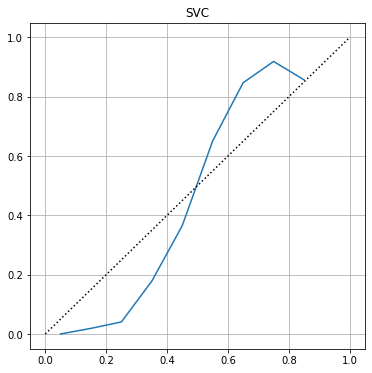

In [ ]:
plot_calibration_curve(y_test, svc_preds)
plt.plot([0, 1], [0, 1], linestyle='dotted', color='black')
plt.title('SVC')
plt.show()

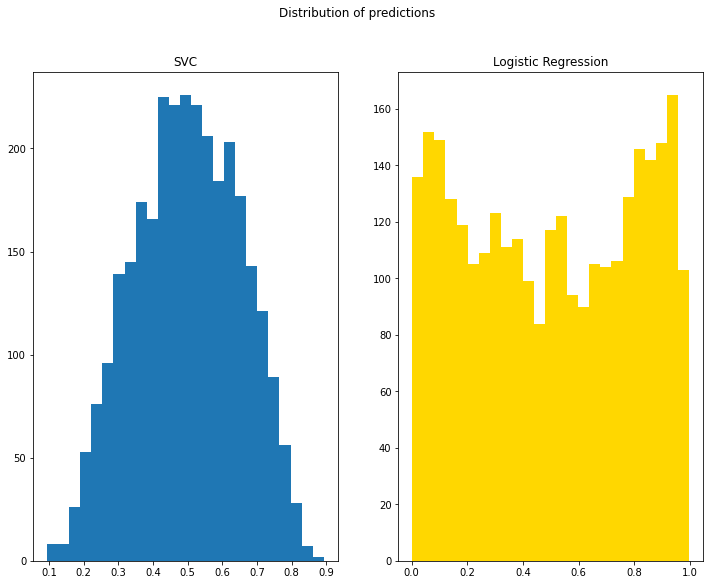

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 9))
ax[0].hist(svc_preds, bins=25)
ax[0].set_title('SVC')
ax[1].hist(logreg_preds, color='gold', bins=25)
ax[1].set_title('Logistic Regression')
fig.suptitle('Distribution of predictions')
plt.show()

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

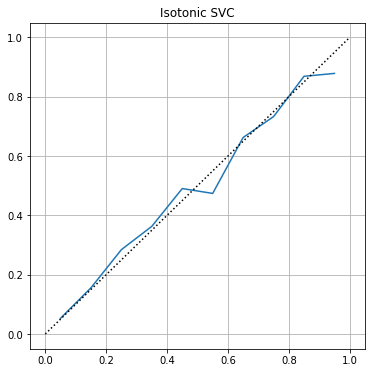

In [ ]:
isotonic_svc = CalibratedClassifierCV(svc, cv=5, method='isotonic')
isotonic_svc.fit(X_train, y_train)
isotonic_svc_preds = isotonic_svc.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, isotonic_svc_preds)
plt.plot([0, 1], [0, 1], linestyle='dotted', color='black')
plt.title('Isotonic SVC')
plt.show()

__Бонусное задание (0.5 балла).__ Реализуйте свою функцию для калибровки вероятностей. Опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [ ]:
#your code here

# Часть 1. Работа с переменными.

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
import time

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [ ]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [ ]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его. 



Из описания датасета:

duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

In [ ]:
del df['duration']
df['y'] = df['y'].map({'yes': 1, 'no': 0})
target = df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1],
                                                    target,
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    random_state=777,
                                                    stratify=target)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__: поскольку `AUC-PR` менее чувствителен к дисбалансу классов

In [ ]:
df['y'].value_counts() / len(df)

0    0.887346
1    0.112654
Name: y, dtype: float64

In [ ]:
cat_features = X_train.dtypes[X_train.dtypes == 'object'].index.tolist()
num_features = [c for c in X_train.columns if c not in cat_features]

In [ ]:
def preprocess(train,
               test,
               encoder,
               cat_features,
               num_features,
               train_target=None):
    if train_target is not None:
        categorical_train = encoder.fit_transform(train[cat_features],
                                                  train_target)
    else:
        categorical_train = encoder.fit_transform(train[cat_features])
    categorical_test = encoder.transform(test[cat_features])
    if type(categorical_train) != np.ndarray:
        categorical_train = categorical_train.toarray()
        categorical_test = categorical_test.toarray()
    num_train = scaler.fit_transform(train[num_features])
    num_test = scaler.transform(test[num_features])
    train = np.hstack([num_train, categorical_train])
    test = np.hstack([num_test, categorical_test])
    #train = scaler.fit_transform(train)
    #test = scaler.transform(test)
    return train, test

In [ ]:
def fit_logreg(train,
               train_target,
               test,
               test_target,
               encoder,
               num_features=num_features,
               cat_features=cat_features,
               mean_enc=False):
    score_list = []
    start_time = time.time()
    if mean_enc:
        train, test = preprocess(train,
                                 test,
                                 encoder,
                                 cat_features,
                                 num_features,
                                 train_target=train_target)
    else:
        train, test = preprocess(train, test, encoder, cat_features,
                                 num_features)

    skf = StratifiedKFold(5, shuffle=True, random_state=777)
    for trn_index, val_index in skf.split(train, train_target):
        X_tr = train[trn_index]
        y_tr = train_target[trn_index]
        X_va = train[val_index]
        y_va = train_target[val_index]
        model = LogisticRegression(max_iter=10000)
        model.fit(X_tr, y_tr)
        preds = model.predict_proba(X_va)[:, 1]
        score_list.append(auc_pr_score(y_va, preds))
    model.fit(train, train_target)
    test_preds = model.predict_proba(test)[:, 1]
    end_time = time.time()
    test_score = auc_pr_score(test_target, test_preds)
    cv_score = np.round(np.mean(score_list), 5)
    return cv_score, test_score, end_time - start_time

In [ ]:
cv_score, test_score, time_taken = fit_logreg(X_train, y_train, X_test, y_test,
                                              OrdinalEncoder())
print(
    f"Logistic Regression with Ordinal Encoder\nCV score: {cv_score}\ntest score: {test_score}\ntime: {time_taken:.5f} sec"
)

Logistic Regression with Ordinal Encoder
CV score: 0.44089
test score: 0.44184
time: 2.57904 sec


__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
cv_score, test_score, time_taken = fit_logreg(X_train, y_train, X_test, y_test,
                                              OneHotEncoder())
print(
    f"Logistic Regression with One Hot Encoder\nCV score: {cv_score}\ntest score: {test_score}\ntime: {time_taken:.5f} sec"
)

Logistic Regression with One Hot Encoder
CV score: 0.4514
test score: 0.44923
time: 14.74692 sec


Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — mean-target encoding (для простоты будем называть это счётчиками). Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?


__Бонус (1 балл)__: Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 


In [ ]:
class MeanTargetEncoding(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encode_values = []

    def mean_target_encoding(self, X, y):
        numerator = X.iloc[y == 1].value_counts()
        denominator = X.value_counts()
        res = numerator / denominator
        return dict(res)

    def fit(self, X, y):
        self.encode_values = []
        for col in X.columns:
            self.encode_values.append(self.mean_target_encoding(X[col], y))

    def transform(self, X):
        for ind in range(len(self.encode_values)):
            X.iloc[:, ind] = X.iloc[:, ind].map(self.encode_values[ind])
        return X.fillna(0).values

    def fit_transform(self, X, y):
        self.fit(X, y)
        X = self.transform(X)
        return X

In [ ]:
cv_score, test_score, time_taken = fit_logreg(X_train,
                                              y_train,
                                              X_test,
                                              y_test,
                                              MeanTargetEncoding(),
                                              mean_enc=True)
print(
    f"Logistic Regression with Mean encoding\nCV score: {cv_score}\ntest score: {test_score}\ntime: {time_taken:.5f} sec"
)

Logistic Regression with Mean encoding
CV score: 0.43697
test score: 0.44235
time: 4.22313 sec


Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 6.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(0.5 балла)__

In [ ]:
class NoisyMeanTargetEncoding(MeanTargetEncoding):
    def __init__(self, scaler_coef):
        self.encode_values = []
        self.scaler_coef = scaler_coef

    def mean_target_encoding(self, X, y):
        numerator = X.iloc[y == 1].value_counts()
        denominator = X.value_counts()
        res = numerator / denominator
        res += np.random.rand(len(res)) / self.scaler_coef
        return dict(res)

In [ ]:
for coef in [0.5, 1, 5, 10, 25, 50, 100, 1000]:
    cv_score, test_score, _ = fit_logreg(X_train,
                                         y_train,
                                         X_test,
                                         y_test,
                                         NoisyMeanTargetEncoding(coef),
                                         mean_enc=True)
    print(coef)
    print(
        f"Logistic Regression with Mean encoding with noise\nCV score: {cv_score}\ntest score: {test_score}"
    )

0.5
Logistic Regression with Mean encoding with noise
CV score: 0.43783
test score: 0.43894
1
Logistic Regression with Mean encoding with noise
CV score: 0.43243
test score: 0.43746
5
Logistic Regression with Mean encoding with noise
CV score: 0.42841
test score: 0.43875
10
Logistic Regression with Mean encoding with noise
CV score: 0.43313
test score: 0.43773
25
Logistic Regression with Mean encoding with noise
CV score: 0.43575
test score: 0.44082
50
Logistic Regression with Mean encoding with noise
CV score: 0.43701
test score: 0.44242
100
Logistic Regression with Mean encoding with noise
CV score: 0.43694
test score: 0.44244
1000
Logistic Regression with Mean encoding with noise
CV score: 0.437
test score: 0.44232


__(Бонусная часть, 0.5 балла)__ Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум). 



А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!


__Задание 7 (1 балл).__ Добавьте сглаживание, описанное выше и повторите эксперименты.

In [ ]:
class SmoothMeanTargetEncoding(MeanTargetEncoding):
    def __init__(self, C):
        self.encode_values = []
        self.C = C

    def mean_target_encoding(self, X, y):
        numerator = X.iloc[y == 1].value_counts() + self.C * y.mean()
        denominator = X.value_counts() + self.C
        res = numerator / denominator
        return dict(res)

In [ ]:
for c in np.linspace(0, 1, 11):
    cv_score, test_score, _ = fit_logreg(X_train,
                                         y_train,
                                         X_test,
                                         y_test,
                                         SmoothMeanTargetEncoding(c),
                                         mean_enc=True)
    print(round(c, 1))
    print(
        f"Logistic Regression with Mean encoding with smoothing\nCV score: {cv_score}\ntest score: {test_score}"
    )

0.0
Logistic Regression with Mean encoding with smoothing
CV score: 0.43697
test score: 0.44235
0.1
Logistic Regression with Mean encoding with smoothing
CV score: 0.43695
test score: 0.4423
0.2
Logistic Regression with Mean encoding with smoothing
CV score: 0.43701
test score: 0.4423
0.3
Logistic Regression with Mean encoding with smoothing
CV score: 0.43692
test score: 0.44232
0.4
Logistic Regression with Mean encoding with smoothing
CV score: 0.437
test score: 0.44235
0.5
Logistic Regression with Mean encoding with smoothing
CV score: 0.43701
test score: 0.44228
0.6
Logistic Regression with Mean encoding with smoothing
CV score: 0.437
test score: 0.44231
0.7
Logistic Regression with Mean encoding with smoothing
CV score: 0.43699
test score: 0.44231
0.8
Logistic Regression with Mean encoding with smoothing
CV score: 0.43699
test score: 0.44232
0.9
Logistic Regression with Mean encoding with smoothing
CV score: 0.43701
test score: 0.44233
1.0
Logistic Regression with Mean encoding wit

__Задание 8 (0.5 балла).__ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [ ]:
print(f'Количество уникальных значений признака "age": {df["age"].nunique()}')

Количество уникальных значений признака "age": 78


In [ ]:
cat_tmp = cat_features + ['age']
num_tmp = [c for c in num_features if c != 'age']
cv_score, test_score, time_taken = fit_logreg(X_train,
                                              y_train,
                                              X_test,
                                              y_test,
                                              SmoothMeanTargetEncoding(0.5),
                                              mean_enc=True,
                                              cat_features=cat_tmp,
                                              num_features=num_tmp)
print(
    f"Logistic Regression with Mean encoding with smoothing\nCV score: {cv_score}\ntest score: {test_score}\ntime: {time_taken:.5f} sec"
)

Logistic Regression with Mean encoding with smoothing
CV score: 0.4397
test score: 0.43714
time: 4.00087 sec


Качество на кросс-валидации улучшилось, на тестовой выборке ухудшилось

Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [ ]:
months = {
    'jan': 1,
    'feb': 2,
    'mar': 3,
    'apr': 4,
    'may': 5,
    'jun': 6,
    'jul': 7,
    'aug': 8,
    'sep': 9,
    'oct': 10,
    'nov': 11,
    'dec': 12
}
days = {'mon': 0, 'tue': 1, 'wed': 2, 'thu': 3, 'fri': 4}

In [ ]:
X_train_tmp = X_train.copy()
X_train_tmp['day_of_week'] = X_train['day_of_week'].map(days)
X_train_tmp['month'] = X_train['month'].map(months)

X_test_tmp = X_test.copy()
X_test_tmp['day_of_week'] = X_test['day_of_week'].map(days)
X_test_tmp['month'] = X_test['month'].map(months)

In [ ]:
num_tmp = num_features + ['month', 'day_of_week']
cat_tmp = [c for c in cat_features if c not in num_tmp]

In [ ]:
num_tmp = num_features + ['month', 'day_of_week']
cat_tmp = [c for c in cat_features if c not in num_tmp]
cv_score, test_score, time_taken = fit_logreg(X_train_tmp,
                                              y_train,
                                              X_test_tmp,
                                              y_test,
                                              SmoothMeanTargetEncoding(0.3),
                                              mean_enc=True,
                                              cat_features=cat_tmp,
                                              num_features=num_tmp)
print(
    f"Logistic Regression with Mean encoding with smoothing\nCV score: {cv_score}\ntest score: {test_score}\ntime: {time_taken:.5f} sec"
)

Logistic Regression with Mean encoding with smoothing
CV score: 0.43853
test score: 0.43452
time: 4.79355 sec


Качество на кросс-валидации улучшилось, на отложенной выборке - ухудшилось

__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ Плюсы: меньшее количество признаков, зачастую лучшее качество

Минусы: возможно переобучение

# Часть 2. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про банковский телефонный маркетинг.

In [ ]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=777,
                                                    stratify=y)

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [ ]:
X_tr, X_te = preprocess(X_train, X_test, OneHotEncoder(), cat_features,
                        num_features)

In [ ]:
print(f"Исходное количество признаков: {X_train.shape[1]}")
print(f"Количество признаков после one-hot кодирования: {X_tr.shape[1]}")

Исходное количество признаков: 19
Количество признаков после one-hot кодирования: 62


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [ ]:
%time
model = LogisticRegression(max_iter=10000)
model.fit(X_tr, y_train)
test_preds = model.predict_proba(X_te)[:, 1]
test_score = auc_pr_score(y_test, test_preds)
print(f'Test AUC-PR: {test_score:.5f}')
best_feats = np.argsort(-np.abs(model.coef_.reshape(-1)))[:40]

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs
Test AUC-PR: 0.44729


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

__Задание 8 (0.5 балла).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?



In [ ]:
def get_score(train, test, y_train, y_test, features):
    model.fit(train[:, features], y_train)
    test_preds = model.predict_proba(test[:, features])[:, 1]
    test_score = auc_pr_score(y_test, test_preds)
    print(f'Test AUC-PR: {test_score:.5f}')

In [ ]:
get_score(X_tr, X_te, y_train, y_test, best_feats)

Test AUC-PR: 0.44832


Качество улучшилось

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [ ]:
ohe = OneHotEncoder(sparse=False)
X_tr = np.hstack(
    [X_train[num_features].values,
     ohe.fit_transform(X_train[cat_features])])
X_te = np.hstack(
    [X_test[num_features].values,
     ohe.transform(X_test[cat_features])])
model.fit(X_tr, y_train)
test_preds = model.predict_proba(X_te)[:, 1]
test_score = auc_pr_score(y_test, test_preds)
print(f'Test AUC-PR: {test_score:.5f}')

Test AUC-PR: 0.44557


In [ ]:
best_feats = np.argsort(-np.abs(model.coef_.reshape(-1)))[:40]
get_score(X_tr, X_te, y_train, y_test, best_feats)

Test AUC-PR: 0.44470


Если не масштабировать данные, то качество и на исходном наборе признаков, и на 40 лучших с точки зрения модели будет хуже

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [ ]:
X_tr = scaler.fit_transform(X_tr)
X_te = scaler.transform(X_te)
model.fit(X_tr, y_train)
test_preds = model.predict_proba(X_te)[:, 1]
test_score = auc_pr_score(y_test, test_preds)
print(f'Test AUC-PR: {test_score:.5f}')

Test AUC-PR: 0.44726


In [ ]:
best_feats = np.argsort(-np.abs(model.coef_.reshape(-1)))[:40]
get_score(X_tr, X_te, y_train, y_test, best_feats)

Test AUC-PR: 0.44818


Качество оказалось хуже (4 знак после запятой) отностительно немасштабирования

### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 9 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



In [ ]:
def t_stat(X, y):
    X_plus = X[y > 0]
    X_minus = X[y == 0]
    mu_plus = X_plus.mean()
    mu_minus = X_minus.mean()
    n_plus = len(X_plus)
    n_minus = len(X_minus)
    sigma_plus = X_plus.std()
    sigma_minus = X_minus.std()
    numerator = np.abs(mu_plus - mu_minus)
    denominator = np.sqrt(
        (n_plus * sigma_plus**2 + n_minus * sigma_minus**2) / (len(y)))
    return numerator / denominator

In [ ]:
ohe = OneHotEncoder(sparse=False)
X_train = np.hstack([
    scaler.fit_transform(X_train[num_features]),
    ohe.fit_transform(X_train[cat_features])
])
X_test = np.hstack([
    scaler.transform(X_test[num_features]),
    ohe.transform(X_test[cat_features])
])

In [ ]:
%time
scores = np.array([])
for ind in range(X_train.shape[1]):
    t_score = t_stat(X_train[:, ind], y_train)
    scores = np.append(scores, t_score)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.72 µs


In [ ]:
best_feats = np.argsort(scores)[-40:]
get_score(X_train, X_test, y_train, y_test, best_feats)

Test AUC-PR: 0.45122


Качество оказалось лучше, чем при отборе моделью

### Методы-обёртки

__Задание 10 (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(X_tr,
                                            y_train,
                                            stratify=y_train,
                                            shuffle=True,
                                            random_state=42)

In [ ]:
features = list(range(X_tr.shape[1]))
while len(features) > 40:
    best_feat = ''
    best_auc = 0
    for feat in features:
        cur_features = list(set(features) - set([feat]))
        model = LogisticRegression(max_iter=10000)
        model.fit(X_tr[:, cur_features], y_tr)
        score = auc_pr_score(y_val,
                             model.predict_proba(X_val[:, cur_features])[:, 1])
        if score > best_auc:
            best_auc = score
            best_feat = feat
    features.remove(best_feat)

In [ ]:
get_score(X_train, X_test, y_train, y_test, features)

Test AUC-PR: 0.44827


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [ ]:
features = []
all_features = list(range(X_train.shape[1]))
while len(features) < 40:
    best_feat = ''
    best_auc = 0
    for feat in all_features:
        cur_features = features + [feat]
        model = LogisticRegression(max_iter=10000)
        model.fit(X_tr[:, cur_features], y_tr)
        score = auc_pr_score(y_val,
                             model.predict_proba(X_val[:, cur_features])[:, 1])
        if score > best_auc:
            best_auc = score
            best_feat = feat
    features.append(best_feat)
    all_features.remove(best_feat)

In [ ]:
get_score(X_train, X_test, y_train, y_test, features)

Test AUC-PR: 0.43910


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** 
1.  Метод на основе модели: быстро, довольно хорошее качество. Минусы - в некоторых ситуациях может оказаться так, что бесполезный признак будет иметь большие веса
2.  t-статистика: Быстро, в данном случае лучшее качество. Минусы - не учитывает взаимодействие данного признака с другими
3.  Методы-обертки: Неплохое качество, но очень долгое время выполнения

# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 11 (1 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
ohe = OneHotEncoder(sparse=False)
X = df.drop(columns='y')
y = df['y'].map({'yes': 1, 'no': 0}).values

In [ ]:
def get_prediction(train_index, val_index, C=1):
    X_train = X.loc[train_index]
    y_train = y[train_index]
    X_val = X.loc[val_index]
    y_val = y[val_index]
    X_train = np.hstack([
        scaler.fit_transform(X_train[num_features]),
        ohe.fit_transform(X_train[cat_features])
    ])
    X_val = np.hstack([
        scaler.transform(X_val[num_features]),
        ohe.transform(X_val[cat_features])
    ])
    model = LogisticRegression(max_iter=10000, C=C)
    model.fit(X_train, y_train)
    test_preds = model.predict(X_val)
    test_proba = model.predict_proba(X_val)[:, 1]
    return test_preds, test_proba

In [ ]:
income = []
profit = []

kf = KFold(5, shuffle=True, random_state=500)
for train_index, val_index in kf.split(X, y):
    y_val = y[val_index]
    test_preds, _ = get_prediction(train_index, val_index)
    income.append((y_val[test_preds == 1] == 1).sum() * 10)
    profit.append(income[-1] - test_preds.sum())

In [ ]:
print(f"Средняя выручка : {np.mean(income):.0f}")
print(f"Средняя прибыль : {np.mean(profit):.0f}")
print(f"Стандартное отклонение прибыли : {np.std(profit):.0f}")
print(f"Выплата операторам : {np.mean(income)-np.mean(profit):.0f}")

Средняя выручка : 2130
Средняя прибыль : 1806
Стандартное отклонение прибыли : 109
Выплата операторам : 324


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [ ]:
income = []
profit = []

kf = KFold(5, shuffle=True, random_state=500)
for train_index, val_index in kf.split(X, y):
    y_val = y[val_index]
    test_preds, _ = get_prediction(train_index, val_index)
    moneys = test_preds * np.random.rand(len(test_preds)) * 20
    income.append((moneys[np.logical_and(moneys, y_val)]).sum())
    profit.append(income[-1] - test_preds.sum())

In [ ]:
print(f"Средняя выручка : {np.mean(income):.0f}")
print(f"Средняя прибыль : {np.mean(profit):.0f}")
print(f"Стандартное отклонение прибыли : {np.std(profit):.0f}")
print(f"Выплата операторам : {np.mean(income)-np.mean(profit):.0f}")

Средняя выручка : 2187
Средняя прибыль : 1863
Стандартное отклонение прибыли : 99
Выплата операторам : 324


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, также укажите стандартные отклонения (вам поможет `plt.errorbar`).

In [ ]:
search_c = np.logspace(-3, 2, 20)
profit_list = []
profit_std = []
for c in search_c:
    profit = []
    kf = KFold(5, shuffle=True, random_state=500)
    for train_index, val_index in kf.split(X, y):
        y_val = y[val_index]
        test_preds, _ = get_prediction(train_index, val_index, C=c)
        moneys = test_preds * np.random.rand(len(test_preds)) * 20
        income = (moneys[np.logical_and(moneys, y_val)]).sum()
        profit.append(income - test_preds.sum())
    profit_list.append(np.mean(profit))
    profit_std.append(np.std(profit))

In [ ]:
print(
    f"Максимальная выручка : {max(profit_list):.0f} при коэффициенте регуляризации = {search_c[np.argmax(profit_list)]}"
)

Максимальная выручка : 1917 при коэффициенте регуляризации = 54.555947811685144


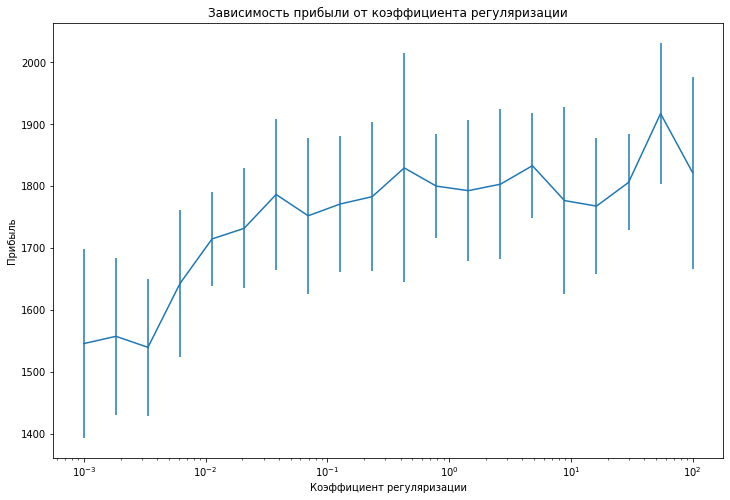

In [ ]:
plt.figure(figsize=(12, 8))
plt.errorbar(search_c, profit_list, yerr=profit_std)
plt.title("Зависимость прибыли от коэффициента регуляризации")
plt.xscale("log")
plt.xlabel("Коэффициент регуляризации")
plt.ylabel("Прибыль")
plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [ ]:
for _ in range(5):
    search_c = np.logspace(-3, 2, 10)
    profit_list = []
    profit_std = []
    for c in search_c:
        profit = []
        kf = KFold(5, shuffle=True, random_state=500)
        for train_index, val_index in kf.split(X, y):
            y_val = y[val_index]
            test_preds, _ = get_prediction(train_index, val_index, C=c)
            moneys = test_preds * np.random.rand(len(test_preds)) * 20
            income = (moneys[np.logical_and(moneys, y_val)]).sum()
            profit.append(income - test_preds.sum())
        profit_list.append(np.mean(profit))
        profit_std.append(np.std(profit))
    print(
        f"Максимальная выручка : {max(profit_list):.0f} при коэффициенте регуляризации = {search_c[np.argmax(profit_list)]}"
    )

Максимальная выручка : 1852 при коэффициенте регуляризации = 0.1668100537200059
Максимальная выручка : 1838 при коэффициенте регуляризации = 7.742636826811277
Максимальная выручка : 1822 при коэффициенте регуляризации = 27.825594022071257
Максимальная выручка : 1833 при коэффициенте регуляризации = 0.5994842503189409
Максимальная выручка : 1851 при коэффициенте регуляризации = 27.825594022071257


Закономерности нет. Каждый раз лучшая прибыль получается при разных значениях коэффициента регуляризации

__Задание 12 (1 балл).__ Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Все зависит от цены за каждый звонок и суммы, которую принесет соглашающийся клиент. Но при данных условиях получается, что важнее recall, так как звонки не такие дорогие, а за счет массового обзвона удастся привлечь большее количество согласившихся клиентов, которые окупят затраты



Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки порога бинаризации этих вероятностей мы сможем получить какой-то выигрыш? Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [ ]:
thresholds = np.linspace(0, 1, 101)
profit = [[] for _ in range(len(thresholds))]

kf = KFold(5, shuffle=True, random_state=500)
for train_index, val_index in kf.split(X, y):
    y_val = y[val_index]
    _, test_proba = get_prediction(train_index, val_index)
    for i in range(len(thresholds)):
        test_preds = np.zeros(len(y_val))
        test_preds[test_proba > thresholds[i]] = 1
        moneys = test_preds * np.random.rand(len(test_preds)) * 20
        income = (moneys[np.logical_and(moneys, y_val)]).sum()
        profit[i] += [income - test_preds.sum()]

In [ ]:
profit_list = np.mean(profit, axis=1)
profit_std = np.std(profit, axis=1)

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

**Ответ:** Максимальная прибыль - при пороге в диапазоне (0.1,0.2), затем при увеличении порога наблюдается снижение прибыли, следовательно, важнее в данном случае recall

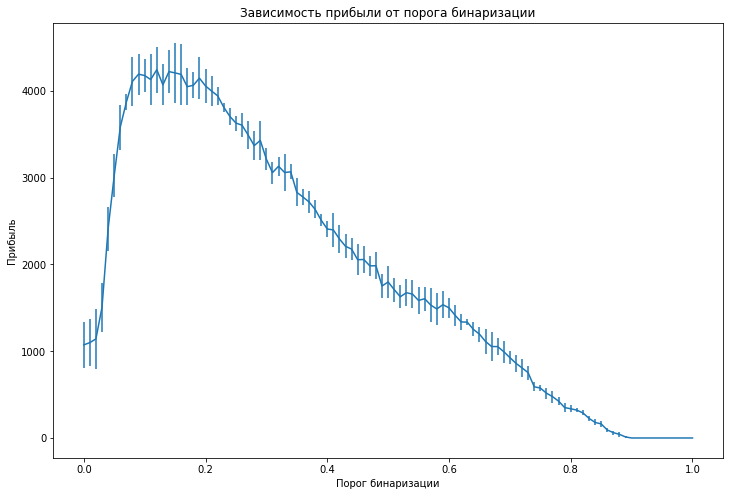

In [ ]:
plt.figure(figsize=(12, 8))
plt.errorbar(thresholds, profit_list, yerr=profit_std)
plt.title("Зависимость прибыли от порога бинаризации")
plt.xlabel("Порог бинаризации")
plt.ylabel("Прибыль")
plt.show()

In [ ]:
print(
    f'Лучшая прибыль: {max(profit_list):.0f} при пороге {thresholds[np.argmax(profit_list)]}'
)

Лучшая прибыль: 4245 при пороге 0.12


Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [ ]:
best_threshold = thresholds[np.argmax(profit_list)]
precision = []
recall = []

kf = KFold(5, shuffle=True, random_state=500)
for train_index, val_index in kf.split(X, y):
    y_val = y[val_index]
    _, test_proba = get_prediction(train_index, val_index)
    test_preds = np.zeros(len(y_val))
    test_preds[test_proba > best_threshold] = 1
    precision.append(precision_score(y_val, test_preds))
    recall.append(recall_score(y_val, test_preds))

In [ ]:
print(f"Precision: {np.mean(precision):.5f} +- {np.std(precision):.5f}")
print(f"Recall: {np.mean(recall):.5f} +- {np.std(recall):.5f}")

Precision: 0.35453 +- 0.01391
Recall: 0.62616 +- 0.02147


Как вы, вероятно, уже поняли, ваша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом - выберите только те пороги, на которых достигается необходимый recall, затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат и посчитайте площадь под отсеченной кривой. 

In [ ]:
thresholds = np.linspace(0, 1, 101)
precision = [[] for _ in range(len(thresholds))]
recall = [[] for _ in range(len(thresholds))]

kf = KFold(5, shuffle=True, random_state=500)
for train_index, val_index in kf.split(X, y):
    y_val = y[val_index]
    _, test_proba = get_prediction(train_index, val_index)
    for i in range(len(thresholds)):
        test_preds = np.zeros(len(y_val))
        test_preds[test_proba > thresholds[i]] = 1
        precision[i] += [precision_score(y_val, test_preds)]
        recall[i] += [recall_score(y_val, test_preds)]

In [ ]:
precision = np.mean(precision, axis=1)
recall = np.mean(recall, axis=1)

precision = precision[recall >= 0.5]
recall = recall[recall >= 0.5]

# scale to 0-1
precision = (precision - min(precision)) / (max(precision) - min(precision))
recall = (recall - min(recall)) / (max(recall) - min(recall))

print(f'PR-AUC: {auc(recall,precision):.5f}')

PR-AUC: 0.40016


__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__

__Социализационный бонус (0.1 балл).__
Введены новые ограничения, занятия теперь дистанционные. Но это не значит, что не надо общаться с друзьями! Созвонитесь в зуме (или любым другим способом) хотя бы с двумя студентами курса МО-1 этого года, приложите скриншот созвона с включенными камерами и напишите очень кратко, на какие темы были беседы.

__Ответ:__